In [1]:
!python -m pip install pinecone sentence-transformers langchain-pinecone langchain langchain-huggingface --quiet


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [2]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings

embeddings = GoogleGenerativeAIEmbeddings(
    model="models/embedding-001"
)

print(len(embeddings.embed_query("hello world")))

/home/zadmin/Desktop/test/GAAI-B5-GCP/genai/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


768


In [3]:
import os
import json
import logging
from typing import List, Tuple, Dict, Any, Optional, TypedDict
import pinecone
from langchain.llms import VertexAI

from pinecone import Pinecone, ServerlessSpec
from langchain.schema import Document
from langchain_google_genai import GoogleGenerativeAIEmbeddings

In [14]:
# Config
JSON_FILE = "datasets/self_critique_loop_dataset.json"
EMBED_MODEL = "models/embedding-001"
INDEX_NAME = "assignment-sagar"
os.environ['PINECONE_API_KEY'] = "pcsk_23rEUe_E7CHN2368jN9x1dE8k4sac9kX6UPQ4h1tLTbBV8HfEXW6DJCVFzKLfKMMdfWcTM"


PINECONE_API_KEY = os.getenv("PINECONE_API_KEY")

In [5]:
# Logging setup
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger("index_kb")

In [6]:
# Helper Functions
def load_kb(file_path: str) -> List[Document]:
    """Load KB JSON into LangChain Documents."""
    logger.info(f"Loading KB from {file_path}")
    with open(file_path, "r", encoding="utf-8") as f:
        kb_data = json.load(f)

    documents = [
        Document(
            page_content=entry["answer_snippet"],
            metadata={
                "doc_id": entry["doc_id"],
                "question": entry["question"],
                "source": entry["source"],
                "last_updated": entry["last_updated"]
            }
        )
        for entry in kb_data
    ]
    logger.info(f"Loaded {len(documents)} documents from KB")
    return documents

In [15]:
def init_pinecone(index_name: str, dimension: int = 768, cloud="aws", region="us-east-1"):
    """Initialize Pinecone index."""
    logger.info(f"Initializing Pinecone index: {index_name}")

    try:
        api_key = PINECONE_API_KEY

        if not api_key or not region:
            raise ValueError("Please set PINECONE_API_KEY and region variable")

        pc = Pinecone(api_key=api_key)

        if index_name not in pc.list_indexes().names():
            logger.info(f"Index {index_name} not found. Creating...")
            pc.create_index(
                name=index_name,
                dimension=dimension,
                metric="cosine",
                spec=ServerlessSpec(cloud=cloud, region=region)
            )
        else:
            logger.info(f"Index {index_name} already exists")
    except Exception as e:
        logger.error("Error at pinecone ",e)

    return pc.Index(index_name)

In [ ]:
from langchain_pinecone import PineconeVectorStore
def embed_and_upsert(docs: List[Document], index):
    """Embed documents in loop (embed_query) and upsert into Pinecone."""
    vectors = []
    embeddings = GoogleGenerativeAIEmbeddings(
    model="models/embedding-001"
    )
    texts = []
    metadatas = []
    ids = []
    for doc in docs:
        texts.append(doc.page_content)
        metadatas.append(doc.metadata)
        ids.append(doc.metadata["doc_id"])

    try:
        vectorstore = PineconeVectorStore(
            index_name=INDEX_NAME,
            embedding=embeddings,
            namespace=None,           # set a namespace string if you want to isolate data
            pinecone_api_key=PINECONE_API_KEY,  # optional; will default to env var
        )
        # Upsert (add) texts into Pinecone via LangChain:
        # vec = embeddings.embed_query(doc.page_content)
        # print("Content", doc.page_content)
        # print("Metadata", doc.metadata)
        # print("ids", doc.metadata["doc_id"])
        vectorstore.add_texts(texts=texts, metadatas=metadatas, ids=ids)
        
    except Exception as e:
        logger.error(f"Error embedding {doc.metadata['doc_id']}: {e}")

    logger.info(f"Upserting {len(texts)} vectors into Pinecone")
    #index.upsert(vectors)
    logger.info("Upsert complete")
    return vectorstore


In [17]:
docs = load_kb(JSON_FILE)
index = init_pinecone(INDEX_NAME)
vectors = embed_and_upsert(docs, index)


2025-10-05 00:44:33,696 - INFO - Loading KB from datasets/self_critique_loop_dataset.json
2025-10-05 00:44:33,698 - INFO - Loaded 30 documents from KB
2025-10-05 00:44:33,699 - INFO - Initializing Pinecone index: assignment-sagar
2025-10-05 00:44:35,302 - INFO - Index assignment-sagar not found. Creating...


Finished


2025-10-05 00:44:43,444 - INFO - Upserting 30 vectors into Pinecone
2025-10-05 00:44:43,445 - INFO - ✅ Upsert complete


In [18]:
!python -m pip install pydantic langchain langchain-community pdfplumber langchain-core langchain-google-genai langgraph faiss-cpu --quiet

I0000 00:00:1759605300.726903    9205 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [19]:
from langgraph.graph import StateGraph,START,END
from langchain_core.prompts import PromptTemplate
from langgraph.graph import StateGraph,START,END

In [ ]:
from langchain.chat_models import init_chat_model
model_name = "gemini-2.0-flash"
llm = init_chat_model(model_name, model_provider="google_genai")
logger.info("initilaized Langchain Chat model")

In [ ]:
message = """
Answer this question using the provided context only. If the context does not have the content to answer the question, say context is irrelevant.
Do not make up the answer, do not provide answer from outside the doc.
{question}

Context:
{context}
"""

ragprompt = PromptTemplate.from_template(message)
logger.info("initilaized Ragprompt")

In [ ]:
message = """
Check if the passed answer is complete for the question with respect to the provided context.
If answer has completeness and satisfactory then return "COMPLETE" else return "REFINE:<missing keywords>".
# Do not return any other explanation just return only "COMPLETE" or "REFINE:<missing keywords>"
Question:
{question}

Context:
{context}

Answer:
{answer}
"""

critiqueprompt = PromptTemplate.from_template(message)
logger.info("initilaized critiqueprompt")

In [ ]:
#Defining state for the langgraph
logger.info("initilaized state for the langgraph")
class ragState(TypedDict):
    question: str
    context: List[Document]
    answer: str
    critique: str

In [52]:
retriever = vectors.as_retriever(search_type="similarity", search_kwargs={"k": 5})
retriever_1 = vectors.as_retriever(search_type="similarity", search_kwargs={"k": 1})

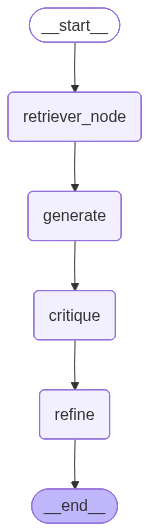

In [86]:
# add modes
def retriever_node(state:ragState):
    ret_docs = retriever.invoke(state["question"])
    logger.info("Retriever Node Finished")
    return {"context":ret_docs}

# generation node
def generate(state:ragState):
    doc_content = "\n\n".join(doc.page_content for doc in state["context"])
    message = ragprompt.invoke({"question":state["question"],"context":doc_content})
    response = llm.invoke(message)
    logger.info("Generate Node Finished")
    return {"answer":response}

# Critique node
def critique(state:ragState):
    doc_content = "\n\n".join(doc.page_content for doc in state["context"])
    message = critiqueprompt.invoke({"question":state["question"],"context":doc_content,"answer":state['answer'].content})
    response = llm.invoke(message)
    logger.info("Critique Node Finished")
    return {"critique":response}

# refine node
def refine(state:ragState):
    if (state['critique'].content.lower() == "complete"):
        logger.info("Refine Node Finished")
        return {"answer":state['answer']}
    else:
        ret_docs = retriever_1.invoke(state["critique"].content)
        doc_content = "\n\n".join(doc.page_content for doc in state["context"])
        doc_content += ret_docs[0].page_content
        message = ragprompt.invoke({"question":state["question"],"context":doc_content})
        response = llm.invoke(message)
        logger.info("Refine Node Finished")
        return {"answer":response}

builder = StateGraph(ragState).add_sequence([retriever_node,generate,critique,refine])
builder.add_edge(START,"retriever_node")
builder.add_edge(["generate","critique","refine"],END)
raggraph = builder.compile()
raggraph

In [87]:
response = raggraph.invoke({"question":"What are best practices for Caching?"})
response['answer'].content

2025-10-05 01:44:00,906 - INFO - Retriever Node Finished
2025-10-05 01:44:01,454 - INFO - Generate Node Finished
2025-10-05 01:44:02,252 - INFO - Critique Node Finished
2025-10-05 01:44:03,832 - INFO - Refine Node Finished


"The context is irrelevant. The provided text mentions the importance of following well-defined patterns when addressing caching, but it doesn't specify what those patterns or best practices are."

In [88]:
response = raggraph.invoke({"question":"How should I set up CI/CD pipelines?"})
response['answer'].content

2025-10-05 01:44:04,656 - INFO - Retriever Node Finished
2025-10-05 01:44:05,177 - INFO - Generate Node Finished
2025-10-05 01:44:05,738 - INFO - Critique Node Finished
2025-10-05 01:44:07,167 - INFO - Refine Node Finished


'Context is irrelevant.'

In [89]:
response = raggraph.invoke({"question":"What are performance tuning tips?"})
response['answer'].content

2025-10-05 01:44:08,003 - INFO - Retriever Node Finished
2025-10-05 01:44:08,594 - INFO - Generate Node Finished
2025-10-05 01:44:09,206 - INFO - Critique Node Finished
2025-10-05 01:44:10,773 - INFO - Refine Node Finished


'Context is irrelevant.'

In [90]:
response = raggraph.invoke({"question":"How do I version my APIs?”"})
response['answer'].content

2025-10-05 01:44:11,584 - INFO - Retriever Node Finished
2025-10-05 01:44:12,172 - INFO - Generate Node Finished
2025-10-05 01:44:12,737 - INFO - Critique Node Finished
2025-10-05 01:44:14,307 - INFO - Refine Node Finished


"The context is irrelevant. While it mentions API versioning, it doesn't provide any information on *how* to version APIs."

In [91]:
response = raggraph.invoke({"question":"What should I consider for error handling?"})
response['answer'].content

2025-10-05 01:44:15,166 - INFO - Retriever Node Finished
2025-10-05 01:44:15,868 - INFO - Generate Node Finished
2025-10-05 01:44:16,624 - INFO - Critique Node Finished
2025-10-05 01:44:18,090 - INFO - Refine Node Finished


"When addressing error handling, it's important to follow well-defined patterns."